<a href="https://colab.research.google.com/github/Tmasterflex1/Creditriskmodel/blob/main/Credit_Risk_Model_with_XGBOOST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CREDIT RISK MODEL**

I will be using the data from a kaggle competition from 2011.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
testdata = '/content/sample_data/Credit model 2011 data/cs-test.csv'
traindata = '/content/sample_data/Credit model 2011 data/cs-training.csv'

#unnamed :0 will get rid of the index numbers, which data doesnt need
train = pd.read_csv(traindata).drop(['Unnamed: 0'],axis=1)
test = pd.read_csv(testdata).drop(['Unnamed: 0'],axis=1)


**Data Exploration**

The data was loaded and labeled as a variable to work with.

Now the data will be looked at and cleaned to get ready to work for the model.

In [4]:
#Finding any duplicate values
train.duplicated().value_counts()

False    149391
True        609
dtype: int64

In [5]:
#Drop duplicate value
train_redup = train.drop_duplicates()

In [7]:
#Check for duplicate value
train_redup.duplicated().sum()

0

In [8]:
train_redup.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [9]:
train_redup.shape

(149391, 11)

In [10]:
#Function turns values into %
def findMiss(df):
  return round(df.isnull().sum()/df.shape[0]*100,2)

In [11]:
findMiss(train_redup)

SeriousDlqin2yrs                         0.00
RevolvingUtilizationOfUnsecuredLines     0.00
age                                      0.00
NumberOfTime30-59DaysPastDueNotWorse     0.00
DebtRatio                                0.00
MonthlyIncome                           19.56
NumberOfOpenCreditLinesAndLoans          0.00
NumberOfTimes90DaysLate                  0.00
NumberRealEstateLoansOrLines             0.00
NumberOfTime60-89DaysPastDueNotWorse     0.00
NumberOfDependents                       2.56
dtype: float64

In [12]:
#filters rows with  missing values in the loans data with customer demographic
train_redup[train_redup.NumberOfDependents.isnull()].describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,3828.000000,3828.000000,3828.000000,3828.000000,3828.000000,0.0,3828.000000,3828.000000,3828.000000,3828.000000,0.0
mean,0.046499,11.003369,59.741641,0.572623,1110.713689,NaN,5.708986,0.497126,0.605799,0.474138,NaN
std,0.210592,240.656436,18.345175,6.527320,4235.410634,NaN,4.086337,6.523199,0.920990,6.520343,NaN
min,0.000000,0.000000,21.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN
25%,0.000000,0.009228,48.000000,0.000000,25.000000,NaN,3.000000,0.000000,0.000000,0.000000,NaN
50%,0.000000,0.047670,61.000000,0.000000,398.000000,NaN,5.000000,0.000000,0.000000,0.000000,NaN
75%,0.000000,0.259028,74.000000,0.000000,1587.000000,NaN,8.000000,0.000000,1.000000,0.000000,NaN
max,1.000000,10821.000000,109.000000,98.000000,220516.000000,NaN,30.000000,98.000000,15.000000,98.000000,NaN


No monthly income means the borrower has no regular or stable monthly income or using another way to qualify like using equity

In [13]:
train_redup['NumberOfDependents'].agg(['mode'])

,mode
0,0.0


In [15]:
train_redup.groupby(['NumberOfDependents']).size()
#Most data has zero dependents

NumberOfDependents
0.0     86392
1.0     26314
2.0     19521
3.0      9483
4.0      2862
5.0       746
6.0       158
7.0        51
8.0        24
9.0         5
10.0        5
13.0        1
20.0        1
dtype: int64

In [17]:
fam_miss = train_redup[train_redup.NumberOfDependents.isnull()]
fam_nmiss = train_redup[train_redup.NumberOfDependents.notnull()]

In [22]:
fam_miss['NumberOfDependents'] = fam_miss['NumberOfDependents'].fillna(0)
fam_miss['MonthlyIncome'] = fam_miss['MonthlyIncome'].fillna(0)

<ipython-input-22-eeda2eaba563>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fam_miss['NumberOfDependents'] = fam_miss['NumberOfDependents'].fillna(0)
<ipython-input-22-eeda2eaba563>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fam_miss['MonthlyIncome'] = fam_miss['MonthlyIncome'].fillna(0)


In [21]:
findMiss(fam_miss)

SeriousDlqin2yrs                          0.0
RevolvingUtilizationOfUnsecuredLines      0.0
age                                       0.0
NumberOfTime30-59DaysPastDueNotWorse      0.0
DebtRatio                                 0.0
MonthlyIncome                           100.0
NumberOfOpenCreditLinesAndLoans           0.0
NumberOfTimes90DaysLate                   0.0
NumberRealEstateLoansOrLines              0.0
NumberOfTime60-89DaysPastDueNotWorse      0.0
NumberOfDependents                        0.0
dtype: float64

In [23]:
findMiss(fam_nmiss)

SeriousDlqin2yrs                         0.00
RevolvingUtilizationOfUnsecuredLines     0.00
age                                      0.00
NumberOfTime30-59DaysPastDueNotWorse     0.00
DebtRatio                                0.00
MonthlyIncome                           17.44
NumberOfOpenCreditLinesAndLoans          0.00
NumberOfTimes90DaysLate                  0.00
NumberRealEstateLoansOrLines             0.00
NumberOfTime60-89DaysPastDueNotWorse     0.00
NumberOfDependents                       0.00
dtype: float64

In [25]:
fam_nmiss['MonthlyIncome'].agg(['mean','median','min'])

mean      6675.098269
median    5400.000000
min          0.000000
Name: MonthlyIncome, dtype: float64

In [26]:
fam_nmiss['MonthlyIncome'].agg(['max'])

max    3008750.0
Name: MonthlyIncome, dtype: float64

We will use the median value to fill the Null values because it is most likely to not be effected by the maximum monthly income

In [27]:
fam_nmiss['MonthlyIncome'] = fam_nmiss['MonthlyIncome'].fillna(fam_nmiss['MonthlyIncome'].median())

<ipython-input-27-55bbbc7c8038>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fam_nmiss['MonthlyIncome'] = fam_nmiss['MonthlyIncome'].fillna(fam_nmiss['MonthlyIncome'].median())


In [28]:
findMiss(fam_nmiss)

SeriousDlqin2yrs                        0.0
RevolvingUtilizationOfUnsecuredLines    0.0
age                                     0.0
NumberOfTime30-59DaysPastDueNotWorse    0.0
DebtRatio                               0.0
MonthlyIncome                           0.0
NumberOfOpenCreditLinesAndLoans         0.0
NumberOfTimes90DaysLate                 0.0
NumberRealEstateLoansOrLines            0.0
NumberOfTime60-89DaysPastDueNotWorse    0.0
NumberOfDependents                      0.0
dtype: float64

shows no missing values

In [29]:
filled_train = fam_nmiss.append(fam_miss)

<ipython-input-29-f1952169a1e3>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filled_train = fam_nmiss.append(fam_miss)


In [30]:
filled_train.shape

(149391, 11)

total number or records after removing duplicates

In [31]:
findMiss(filled_train)

SeriousDlqin2yrs                        0.0
RevolvingUtilizationOfUnsecuredLines    0.0
age                                     0.0
NumberOfTime30-59DaysPastDueNotWorse    0.0
DebtRatio                               0.0
MonthlyIncome                           0.0
NumberOfOpenCreditLinesAndLoans         0.0
NumberOfTimes90DaysLate                 0.0
NumberRealEstateLoansOrLines            0.0
NumberOfTime60-89DaysPastDueNotWorse    0.0
NumberOfDependents                      0.0
dtype: float64

In [32]:
filled_train.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [33]:
filled_train.groupby(['SeriousDlqin2yrs']).size()/filled_train.shape[0]

SeriousDlqin2yrs
0    0.933001
1    0.066999
dtype: float64

In [34]:
filled_train.RevolvingUtilizationOfUnsecuredLines.describe()

count    149391.000000
mean          6.071087
std         250.263672
min           0.000000
25%           0.030132
50%           0.154235
75%           0.556494
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

In [37]:
filled_train['RevolvingUtilizationOfUnsecuredLines'].quantile([.99])

0.99    1.093922
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

In [39]:
filled_train[filled_train['RevolvingUtilizationOfUnsecuredLines'] < 1].describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,146053.000000,146053.000000,146053.000000,146053.000000,146053.000000,1.460530e+05,146053.000000,146053.000000,146053.000000,146053.000000,146053.000000
mean,0.060033,0.302913,52.494827,0.379739,356.946590,6.312113e+03,8.529246,0.229026,1.030188,0.207514,0.736664
std,0.237549,0.336767,14.715735,3.890212,2060.104556,1.308137e+04,5.148874,3.863995,1.132337,3.851532,1.105854
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.028834,42.000000,0.000000,0.177355,3.640000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.144441,52.000000,0.000000,0.368084,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.517573,63.000000,0.000000,0.877956,7.453000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,1.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [43]:
(filled_train[filled_train['RevolvingUtilizationOfUnsecuredLines'] > 10]).groupby(['SeriousDlqin2yrs']).size()

SeriousDlqin2yrs
0    224
1     17
dtype: int64

In [44]:
(filled_train[filled_train['RevolvingUtilizationOfUnsecuredLines'] > 10]).describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000
mean,0.070539,3564.023932,50.630705,0.186722,571.918644,7310.817427,5.763485,0.074689,1.186722,0.087137,0.651452
std,0.256587,5123.802683,14.565389,0.579502,1772.948412,5964.524303,3.114160,0.579711,1.065750,0.559651,1.022093
min,0.000000,11.385230,24.000000,0.000000,0.000800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,941.000000,39.000000,0.000000,0.217813,5000.000000,4.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2012.000000,48.000000,0.000000,0.402560,5400.000000,5.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,4116.000000,62.000000,0.000000,59.000000,8607.000000,7.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,87.000000,3.000000,21395.000000,44472.000000,21.000000,8.000000,9.000000,7.000000,4.000000


In [45]:
util_dropped = filled_train.drop(filled_train[filled_train['RevolvingUtilizationOfUnsecuredLines'] >10].index)

<Axes: ylabel='age'>

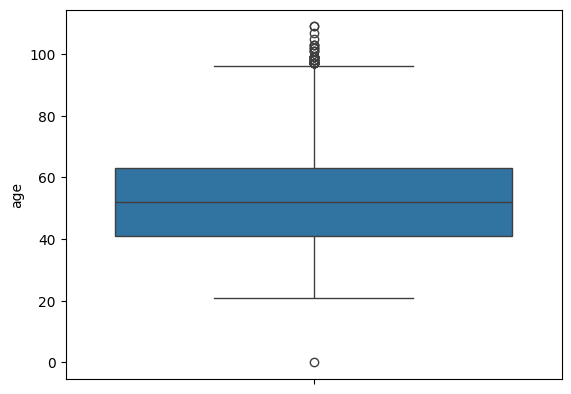

In [47]:
sns.boxplot(util_dropped['age'])

Will use the three columns


*   NumberOfTime30-59DaysPastDueNotWorse
*   NumberOfTime60-89DaysPastDueNotWorse
*   NumberOfTimes90DaysLate






In [48]:
util_dropped.groupby(['NumberOfTime30-59DaysPastDueNotWorse']).size()

NumberOfTime30-59DaysPastDueNotWorse
0     125239
1      16020
2       4588
3       1750
4        747
5        342
6        140
7         54
8         25
9         12
10         4
11         1
12         2
13         1
96         5
98       220
dtype: int64

In [49]:
util_dropped.groupby(['NumberOfTime60-89DaysPastDueNotWorse']).size()

NumberOfTime60-89DaysPastDueNotWorse
0     141601
1       5723
2       1117
3        318
4        104
5         34
6         16
7          8
8          2
9          1
11         1
96         5
98       220
dtype: int64

In [51]:
util_dropped.groupby(['NumberOfTimes90DaysLate']).size()

NumberOfTimes90DaysLate
0     140875
1       5227
2       1554
3        666
4        291
5        131
6         80
7         38
8         20
9         19
10         8
11         5
12         2
13         4
14         2
15         2
17         1
96         5
98       220
dtype: int64

In [59]:
util_dropped[util_dropped['NumberOfTimes90DaysLate']>=96].groupby(['SeriousDlqin2yrs']).size()

SeriousDlqin2yrs
0     89
1    136
dtype: int64

In [61]:
util_dropped['DebtRatio'].describe()

count    149150.000000
mean        354.085328
std        2042.235713
min           0.000000
25%           0.177334
50%           0.368200
75%           0.874241
max      329664.000000
Name: DebtRatio, dtype: float64

<Axes: xlabel='DebtRatio', ylabel='Density'>

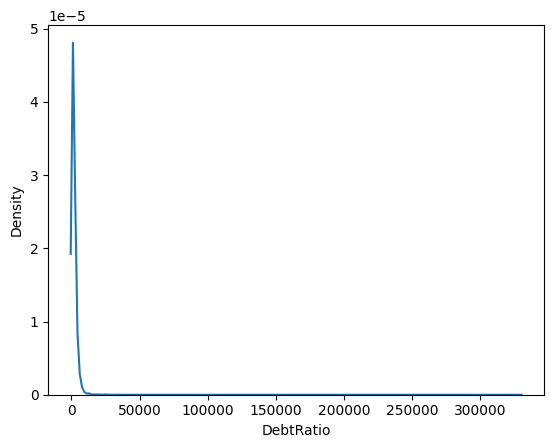

In [62]:
sns.kdeplot(util_dropped["DebtRatio"])

In [75]:
util_dropped['DebtRatio'].quantile([.975])

0.975    3492.0
Name: DebtRatio, dtype: float64

In [79]:
util_dropped[util_dropped['DebtRatio']>3492][['SeriousDlqin2yrs','MonthlyIncome']].describe()

,SeriousDlqin2yrs,MonthlyIncome
count,3727.000000,3727.000000
mean,0.064395,4798.715321
std,0.245488,1698.867567
min,0.000000,0.000000
25%,0.000000,5400.000000
50%,0.000000,5400.000000
75%,0.000000,5400.000000
max,1.000000,5400.000000


In [82]:
temp = util_dropped[(util_dropped['DebtRatio']>3492) & (util_dropped['SeriousDlqin2yrs']==util_dropped['MonthlyIncome'])]

In [84]:
temp.groupby(['SeriousDlqin2yrs']).size()
#we can delete the 380 because only two actually defaulted

SeriousDlqin2yrs
0    380
1      2
dtype: int64

In [90]:
dRatio =  util_dropped.drop(util_dropped[(util_dropped['DebtRatio']>3492) & (util_dropped['SeriousDlqin2yrs']==util_dropped['MonthlyIncome'])].index)

In [91]:
dRatio.shape

(148768, 11)

In [93]:
dRatio.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


This is where we will be using th XGBOOST

In [108]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix , classification_report

In [100]:
model = XGBClassifier(tree_method = 'exact')

In [101]:
x = dRatio.drop(['SeriousDlqin2yrs'],axis=1)
y = dRatio['SeriousDlqin2yrs']

In [102]:
model.fit(x,y.values.ravel())
y_pred = model.predict(x)

In [104]:
accuracy_score(y,y_pred)

0.9465207571520757

In [106]:
cm = confusion_matrix(y,y_pred)

Using Heatmap to display rhe confusion matrix

Text(50.722222222222214, 0.5, 'actuals')

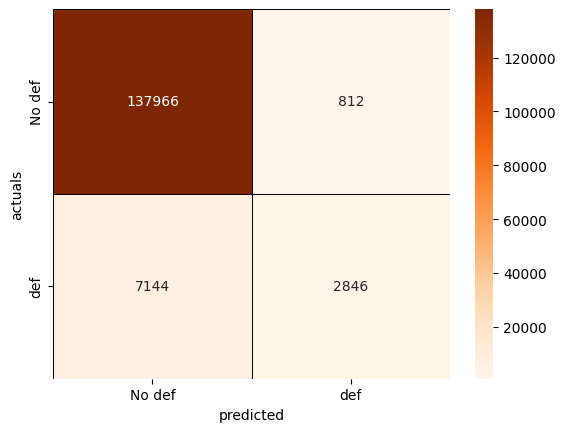

In [107]:
sns.heatmap(cm, annot=True,fmt='d',cmap = 'Oranges', linewidths=0.5,linecolor='Black')
plt.xticks(np.arange(2)+.5,['No def','def'])
plt.yticks(np.arange(2)+.5,['No def','def'])
plt.xlabel('predicted')
plt.ylabel('actuals')

In [112]:
print(classification_report(y,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    138778
           1       0.78      0.28      0.42      9990

    accuracy                           0.95    148768
   macro avg       0.86      0.64      0.69    148768
weighted avg       0.94      0.95      0.93    148768

